# Image Denoising with Deep CNNs
Use deep Convolutional Neural Networks (CNNs) with PyTorch, including investigating DnCNN and U-net architectures

## 1. Get started

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time
import tifffile

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## 2. Creating noisy images of dataset with DataSet

Our goal is to use deep convolutional neural networks to learn the mapping $x_i$ → $y_i$ where $x_i$ are noisy images (our data/observations) and $y_i$ are clean images (our labels/ground-truth). We will consider the images of the siim-medical-images dataset as our clean/ground-truth images: $y_i$. For each of them, we will generate noisy versions by adding white Gaussian noise: $x_i = y_i + w_i$ where $w_i$ is an image where each pixel is an independent realization of a zero-mean Gaussian distribution with standard deviation `σ = 30`.We will consider random crops of size of `180 × 180`.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
dataset_root_dir = '/content/drive/MyDrive/tiff_images'

Mounted at /content/drive


In [61]:
class NoisyDataset(td.Dataset):

    def __init__(self, images_dir, image_size=(200, 200), sigma=50):
        super(NoisyDataset, self).__init__()
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = images_dir
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)


    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        img= tifffile.imread(img_path)
        clean = Image.fromarray(img)
        clean = clean.convert('RGB')   
        # random crop
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # convert it to a tensor
            tv.transforms.ToTensor(),
            # normalize it to the range [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [62]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

#### Build training set and testing set

In [63]:
from sklearn.model_selection import train_test_split

data_set = NoisyDataset(dataset_root_dir)

train_set, test_set = train_test_split(data_set, train_size=0.8, shuffle=True)
print(len(train_set))
print(len(test_set))

80
20


image size is torch.Size([3, 200, 200]).
image size is torch.Size([3, 200, 200]).


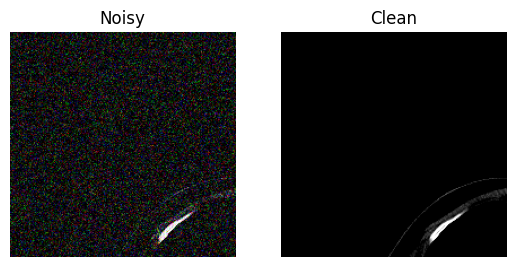

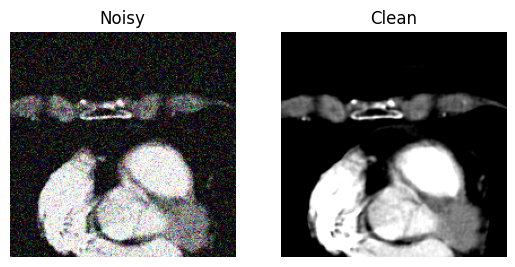

In [64]:
x = train_set[12]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')

x = test_set[12]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')



## 3. DnCNN

#### create a subclass NNRegressor that inherits from NeuralNetwork and implements the method criterion as being the MSE loss.

In [65]:
import os
import time
import torch
from torch import nn
import torch.utils.data as td
from abc import ABC, abstractmethod


class NeuralNetwork(nn.Module, ABC):

    def __init__(self):
        super(NeuralNetwork, self).__init__()

    @property
    def device(self):
        return next(self.parameters()).device

    def named_parameters(self, recurse=True):
        nps = nn.Module.named_parameters(self)
        for name, param in nps:
            if not param.requires_grad:
                continue
            yield name, param

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def criterion(self, y, d):
        pass


class StatsManager(object):

    def __init__(self):
        self.init()

    def __repr__(self):
        return self.__class__.__name__

    def init(self):
        self.running_loss = 0
        self.number_update = 0

    def accumulate(self, loss, x=None, y=None, d=None):
        """
        Arguments:
            loss (float): the loss obtained during the last update.
            x (Tensor): the input of the network during the last update.
            y (Tensor): the prediction of by the network during the last update.
            d (Tensor): the desired output for the last update.
        """
        self.running_loss += loss
        self.number_update += 1

    def summarize(self):
        """Compute statistics based on accumulated ones"""
        return self.running_loss / self.number_update


class Experiment(object):

    def __init__(self, net, train_set, val_set, optimizer, stats_manager,
                 output_dir=None, batch_size=16, perform_validation_during_training=False):

        # Define data loaders
        train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                     drop_last=True, pin_memory=True)
        val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=False,
                                   drop_last=True, pin_memory=True)

        # Initialize history
        history = []

        # Define checkpoint paths
        if output_dir is None:
            output_dir = 'experiment_{}'.format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")

        # Transfer all local arguments/variables into attributes
        locs = {k: v for k, v in locals().items() if k is not 'self'}
        self.__dict__.update(locs)

        # Load checkpoint and check compatibility
        if os.path.isfile(config_path):
            with open(config_path, 'r') as f:
                if f.read()[:-1] != repr(self):
                    raise ValueError(
                        "Cannot create this experiment: "
                        "I found a checkpoint conflicting with the current setting.")
            self.load()
        else:
            self.save()

    @property
    def epoch(self):
        """Returns the number of epochs already performed."""
        return len(self.history)

    def setting(self):
        """Returns the setting of the experiment."""
        return {'Net': self.net,
                'TrainSet': self.train_set,
                'ValSet': self.val_set,
                'Optimizer': self.optimizer,
                'StatsManager': self.stats_manager,
                'BatchSize': self.batch_size,
                'PerformValidationDuringTraining': self.perform_validation_during_training}

    def __repr__(self):
        """Pretty printer showing the setting of the experiment. This is what
        is displayed when doing ``print(experiment)``. This is also what is
        saved in the ``config.txt`` file.
        """
        string = ''
        for key, val in self.setting().items():
            string += '{}({})\n'.format(key, val)
        return string

    def state_dict(self):
        """Returns the current state of the experiment."""
        return {'Net': self.net.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history}

    def load_state_dict(self, checkpoint):
        """Loads the experiment from the input checkpoint."""
        self.net.load_state_dict(checkpoint['Net'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        self.history = checkpoint['History']

        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.net.device)

    def save(self):
        """Saves the experiment on disk, i.e, create/update the last checkpoint."""
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)

    def load(self):
        """Loads the experiment from the last checkpoint saved on disk."""
        checkpoint = torch.load(self.checkpoint_path,
                                map_location=self.net.device)
        self.load_state_dict(checkpoint)
        del checkpoint

    def run(self, num_epochs, plot=None):
        self.net.train()
        self.stats_manager.init()
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        if plot is not None:
            plot(self)
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            self.stats_manager.init()
            for x, d in self.train_loader:
                x, d = x.to(self.net.device), d.to(self.net.device)
                self.optimizer.zero_grad()
                y = self.net.forward(x)
                loss = self.net.criterion(y, d)
                loss.backward()
                self.optimizer.step()
                with torch.no_grad():
                    self.stats_manager.accumulate(loss.item(), x, y, d)
            if not self.perform_validation_during_training:
                self.history.append(self.stats_manager.summarize())
                print("Epoch {} | Time: {:.2f}s | Training Loss: {:.6f}".format(
                    self.epoch, time.time() - s, self.history[-1][0]['loss']))
            else:
                self.history.append(
                    (self.stats_manager.summarize(), self.evaluate()))
                print("Epoch {} | Time: {:.2f}s | Training Loss: {:.6f} | Evaluation Loss: {:.6f}".format(
                    self.epoch, time.time() - s, self.history[-1][0]['loss'], self.history[-1][1]['loss']))
            
            self.save()
            if plot is not None:
                plot(self)
        print("Finish training for {} epochs".format(num_epochs))

    def evaluate(self):
        self.stats_manager.init()
        self.net.eval()
        with torch.no_grad():
            for x, d in self.val_loader:
                x, d = x.to(self.net.device), d.to(self.net.device)
                y = self.net.forward(x)
                loss = self.net.criterion(y, d)
                self.stats_manager.accumulate(loss.item(), x, y, d)
        self.net.train()
        return self.stats_manager.summarize()

<>:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-65-919e53f1da22>:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  locs = {k: v for k, v in locals().items() if k is not 'self'}


In [66]:
class NNRegressor(NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

### Importance of weight initialization

#### without weight initialization

In [67]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

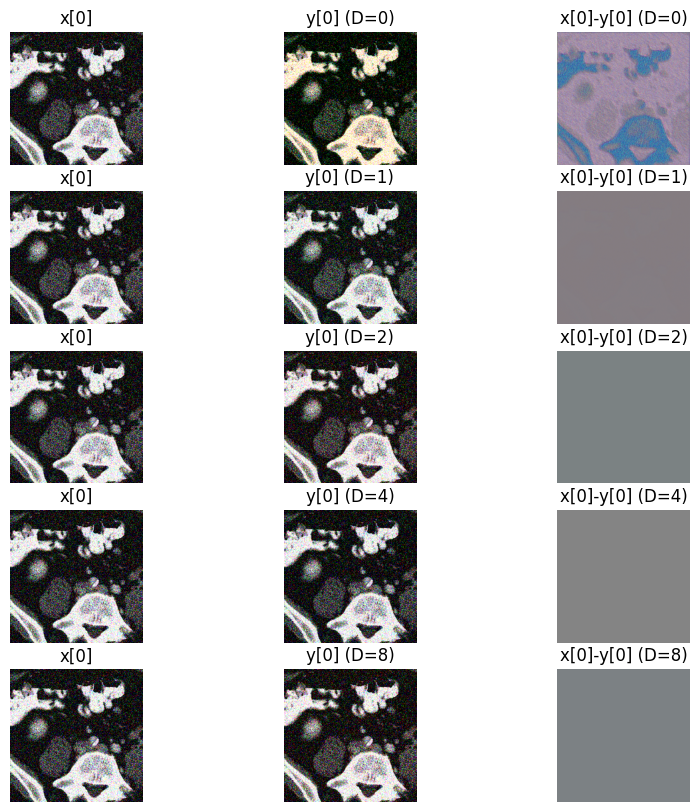

In [68]:

x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(10,10))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)

    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

Except for `DnCNN` with `D=0`, the others have **NO** residuals, showing only gray. It seems that it has gradient vanishment problem. So as the number of layers of a netwrok grows, it is more unlikely for a network to learn. In other words, the output is just like the input, and thus `x[0]-y[0]` is nothing.

As for the implication on backprop, since the output is the same as the input except for `DnCNN` with `D=0`, their gradient and weight update are the same as well, which means the network cannot learn well.

#### with weight initialization

In [69]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

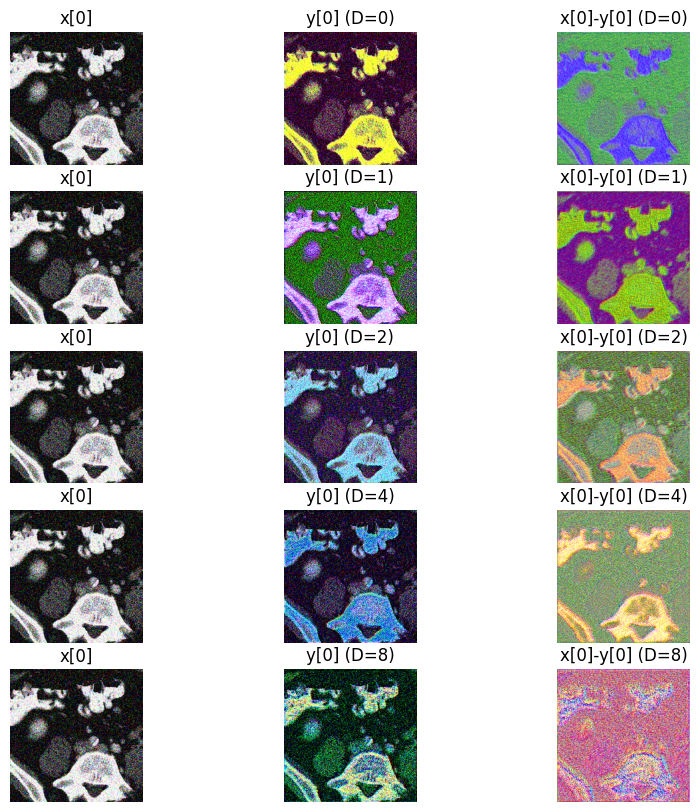

In [70]:
x, _ = train_set[-1]
x = x.unsqueeze(0).to(device)
Ds = [0, 1, 2, 4, 8]

fig, axes = plt.subplots(nrows=len(Ds), ncols=3, figsize=(10,10))
for i in range(len(Ds)):
    with torch.no_grad():
        model = DnCNN(Ds[i]).to(device)
        y = model.forward(x)
    
    myimshow(x[0], ax=axes[i][0])
    axes[i][0].set_title('x[0]')
    myimshow(y[0], ax=axes[i][1])
    axes[i][1].set_title(f'y[0] (D={Ds[i]})')
    myimshow(x[0]-y[0], ax=axes[i][2])
    axes[i][2].set_title(f'x[0]-y[0] (D={Ds[i]})')

`DnCNN` with all different `D` have residual with non-zero values now. This is because He's initialization activates half of the neurons which avoid vanishing gradient in the ReLU. Now, since the output is different from the input, the gradient and weight update are different, enabling the network to learn properly.

#### create the sub-class DenoisingStatsManager that inherits from StatsManager and computes and averages PSNR between mini-batches

In [71]:
class DenoisingStatsManager(StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [72]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None].to(net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()

### train the `DnCNN`

In [88]:
lr = 1e-3
net = DnCNN(7).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4,output_dir="../checkpoints/denoising4", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 143.90s | Training Loss: 0.121928 | Evaluation Loss: 0.075511
Epoch 2 | Time: 142.53s | Training Loss: 0.058676 | Evaluation Loss: 0.048817
Epoch 3 | Time: 141.51s | Training Loss: 0.044712 | Evaluation Loss: 0.038233
Epoch 4 | Time: 140.21s | Training Loss: 0.037395 | Evaluation Loss: 0.032634
Epoch 5 | Time: 139.79s | Training Loss: 0.033349 | Evaluation Loss: 0.030386
Epoch 6 | Time: 136.73s | Training Loss: 0.029204 | Evaluation Loss: 0.025606
Epoch 7 | Time: 139.09s | Training Loss: 0.026694 | Evaluation Loss: 0.025831
Epoch 8 | Time: 136.55s | Training Loss: 0.024710 | Evaluation Loss: 0.023800
Epoch 9 | Time: 137.30s | Training Loss: 0.022832 | Evaluation Loss: 0.020308
Epoch 10 | Time: 136.47s | Training Loss: 0.021319 | Evaluation Loss: 0.021471
Epoch 11 | Time: 137.56s | Training Loss: 0.019897 | Evaluation Loss: 0.019166
Epoch 12 | Time: 136.48s | Training Loss: 0.018675 | Evaluation Loss: 0.018694
Epoch 13 | Time: 138.37s

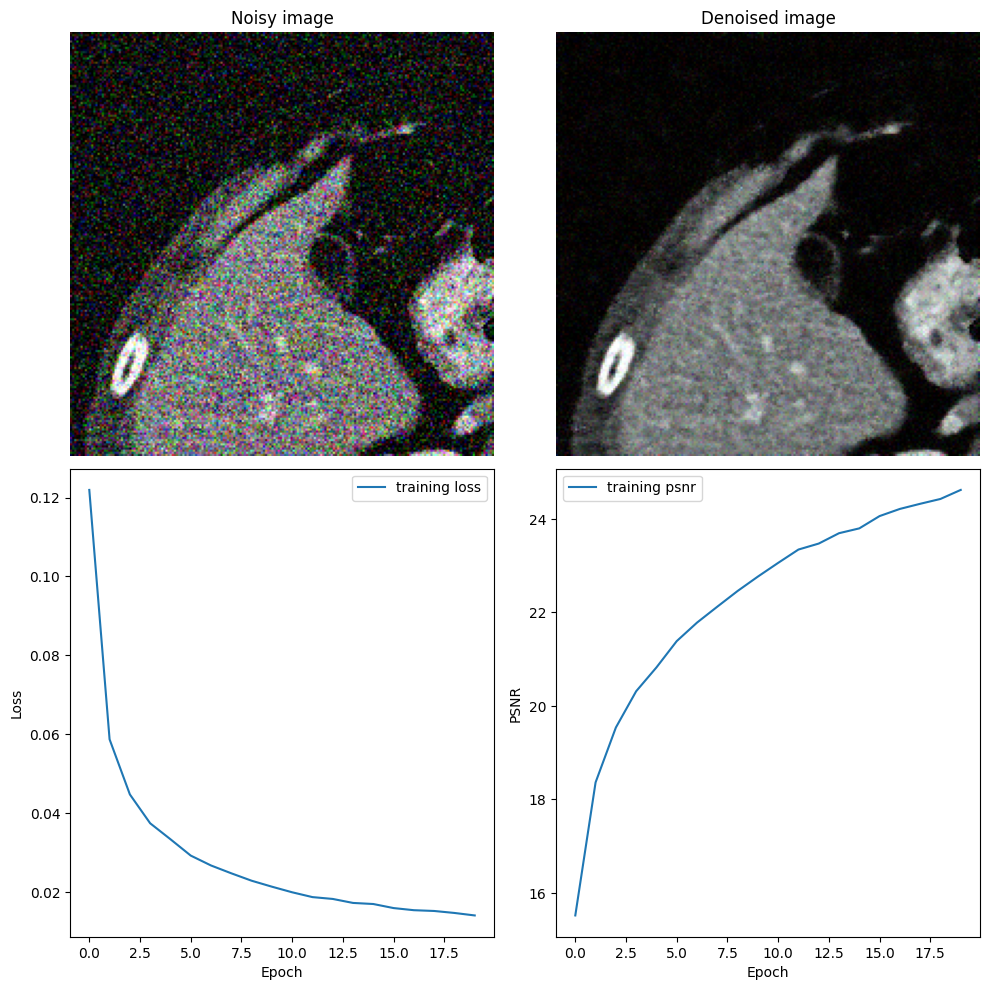

In [89]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[3][0]))

### Performance evaluation

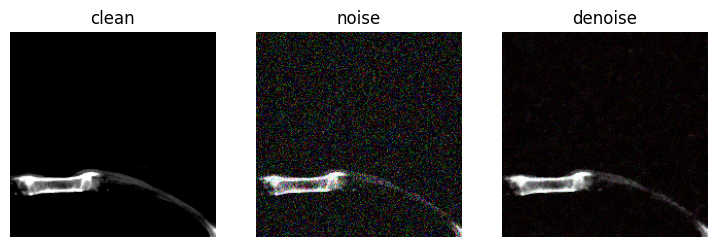

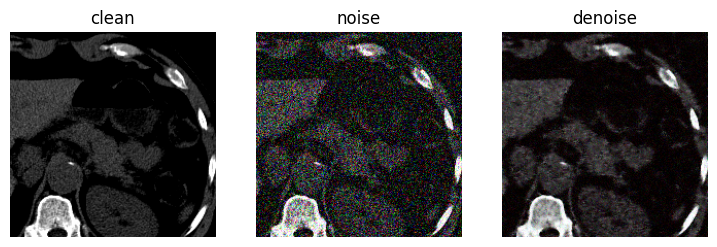

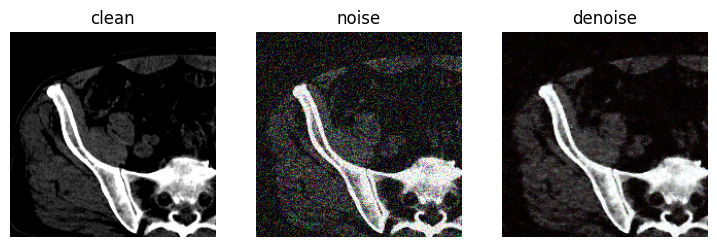

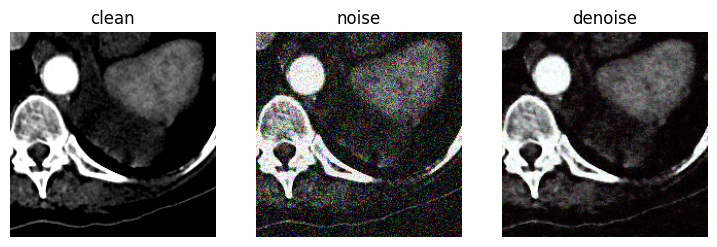

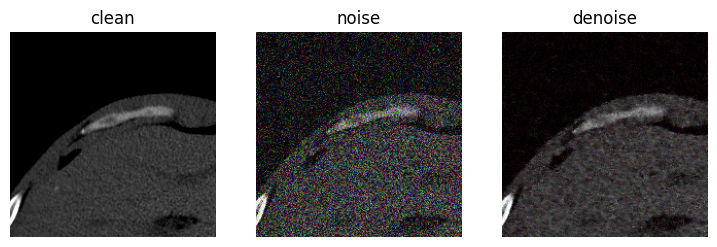

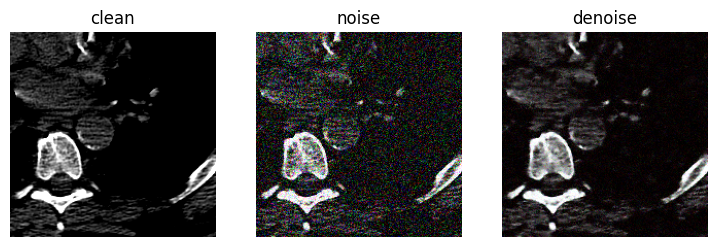

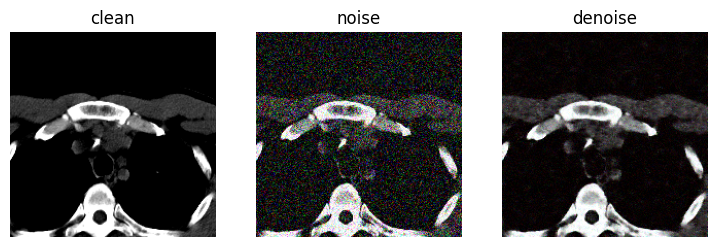

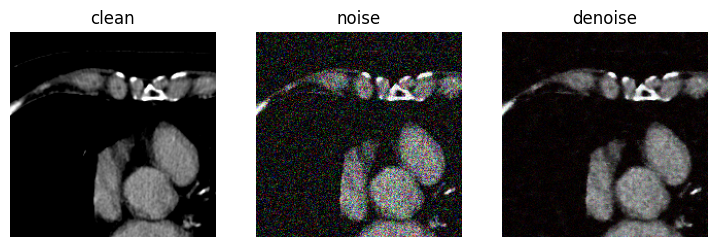

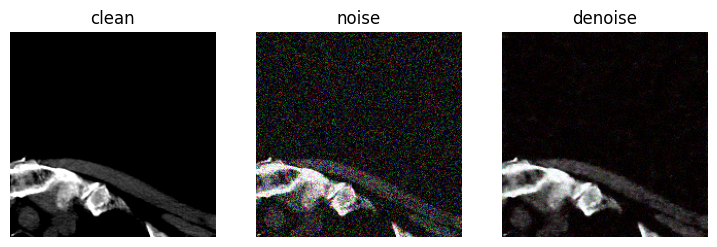

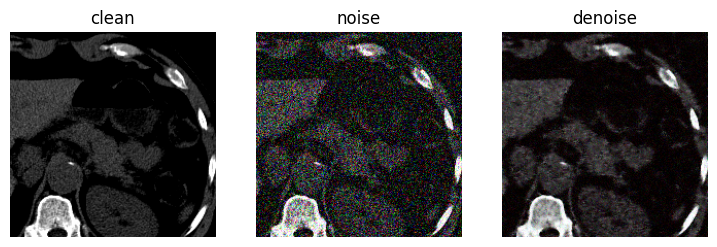

In [90]:
import random
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

for _ in range(10):
  img = []
  index = random.randint(0, 19)
  x, clean = test_set[index]
  x = x.unsqueeze(0).to(device)
  img.append(clean)
  img.append(x[0])
  model.eval()
  with torch.no_grad():
    y = model.forward(x)
  img.append(y[0])
  fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
  for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')


There are some area lost the information. Besides, although the denoise image looks great, based on the PSNR, we can know that noise still exists.

### parameters of `DnCNN`

In [91]:
for name, param in model.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([64, 64, 3, 3]) True
conv.7.bias torch.Size([64]) True
conv.8.weight torch.Size([3, 64, 3, 3]) True
conv.8.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.S

In [92]:
# DnCNN
exp1.evaluate()

{'loss': 0.01201950591057539, 'PSNR': tensor(25.2339)}

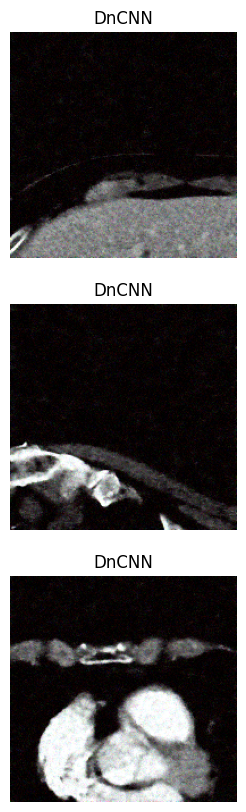

In [93]:
num = 3
img = []
title = 'DnCNN'

for i in range(num):
    x, _ = test_set[4*i+4]
    x = x.unsqueeze(0).to(device)
    img.append(x)

fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(10,10), sharex='all', sharey='all')
for i in range(num):
  model = exp1.net.to(device)
  model.eval()
  with torch.no_grad():
    y = model.forward(img[i])
  myimshow(y[0], ax=axes[i])
  axes[i].set_title(f'{title}')